### Creating Features for Time Series Data

#### Time Series Basics

In [5]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import datetime as dt
from scipy.io import loadmat

import matplotlib.dates as dates
from matplotlib.patches import Rectangle, FancyArrowPatch

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [6]:
df = pd.read_sas("data/tsfm_exdat.sas7bdat", format="sas7bdat", encoding="ISO-8859-1", index="Date")
print(df.shape)
df.head()

(4384, 7)


,BasePrice,sales,promotion,region,type,flag,lsales
Date,,,,,,,
2004-02-22,25.36,6907.0,0.0,reg1,tblre,0.0,NaN
2004-02-29,25.49,4350.0,0.0,reg1,tblre,0.0,6907.0
2004-03-07,25.19,3833.0,0.0,reg1,tblre,0.0,4350.0
2004-03-14,25.70,3746.0,0.0,reg1,tblre,0.0,3833.0
2004-03-21,25.71,4302.0,0.0,reg1,tblre,0.0,3746.0


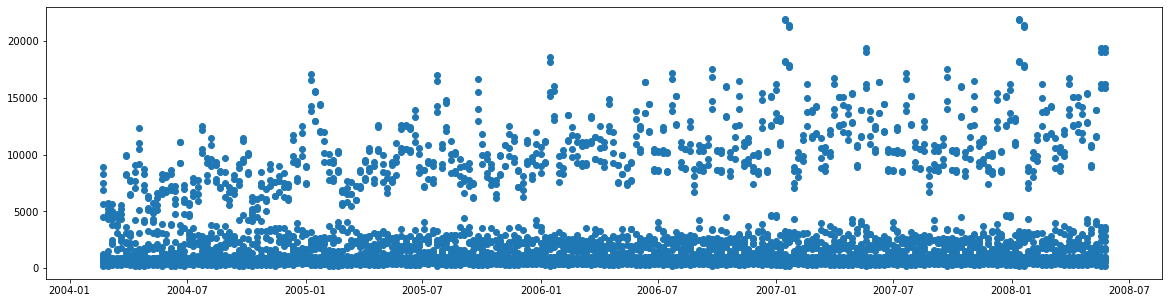

In [7]:
plt.figure(figsize=(20,5))
plt.scatter(x=df.index, y=df["sales"]);

Select wines from region 2 (reg2) and vintage type (vinta) and accumulate on a weekly basis.

Number of observations: 274
Number of missing values: 51


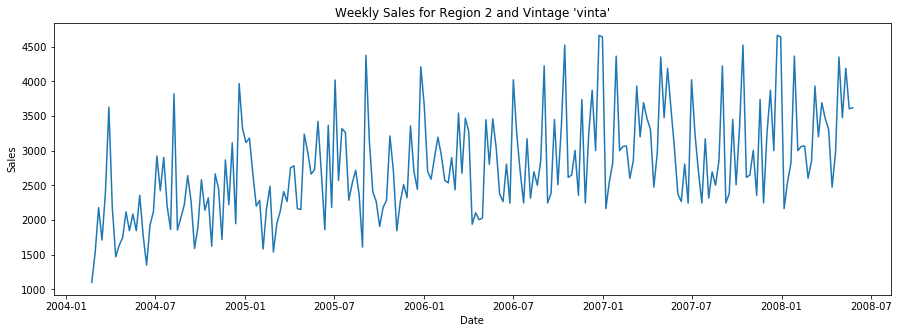

In [8]:
reg2_vintage = df[(df["region"] == "reg2") & (df["type"] == "vinta")]
weekly_sales = reg2_vintage.resample("W").sum()["sales"] # using sum for accumulation
print("Number of observations:", weekly_sales.shape[0])
print("Number of missing values:", np.sum(weekly_sales==0))

weekly_sales = weekly_sales[weekly_sales > 0]
plt.figure(figsize=(15,5))
plt.plot(weekly_sales)
plt.title("Weekly Sales for Region 2 and Vintage 'vinta'")
plt.xlabel("Date")
plt.ylabel("Sales");

Select wines from region 2 (reg2) and vintage type (vinta) and accumulate on a bimonthly basis.

Number of observations: 33
Number of missing values: 0


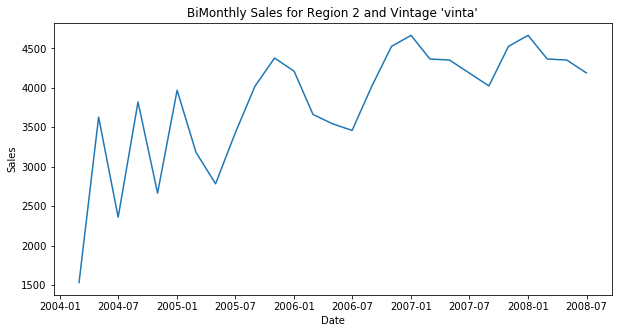

In [9]:
bimonthly_sales = reg2_vintage.resample("2M").max()["sales"] # using max for accumulation
print("Number of observations:", bimonthly_sales.shape[0])
print("Number of missing values:", np.sum(bimonthly_sales==0))

bimonthly_sales = bimonthly_sales[bimonthly_sales > 0]
plt.figure(figsize=(10,5))
plt.plot(bimonthly_sales)
plt.title("BiMonthly Sales for Region 2 and Vintage 'vinta'")
plt.xlabel("Date")
plt.ylabel("Sales");

Accumulate on a monthly basis and plot a centered moving average with window size of 9 and a mean summary statistic.

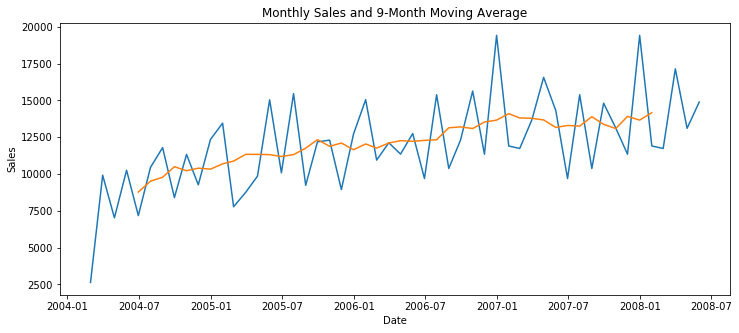

In [10]:
res_m = reg2_vintage.resample("M").sum()["sales"]
res_m = res_m[res_m > 0]
plt.figure(figsize=(12,5))
plt.plot(res_m);
plt.plot(res_m.rolling(window=9, center=True).mean())
plt.title("Monthly Sales and 9-Month Moving Average")
plt.xlabel("Date")
plt.ylabel("Sales");

#### Sequence Distance Basics

The objective of time series comparison methods is to produce a distance metric between two input time series. The similarity or dissimilarity of two-time series is typically calculated by converting the data into vectors and calculating the Euclidean distance between those points in vector space.

Dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences, which may vary in speed.

DTW in Python is a family of algorithms which compute the local stretch or compression to apply to the time axes of two timeseries in order to optimally map one (query) onto the other (reference). DTW outputs the remaining cumulative distance between the two and, if desired, the mapping itself (warping function). DTW is widely used e.g. for classification and clustering tasks in econometrics, chemometrics and general timeseries mining.

https://www.databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html

In [11]:
from fastdtw import fastdtw
from dtw import *
from scipy.spatial.distance import euclidean

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Helper Functions

In [12]:
def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist

def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

6.0
[(0, 0), (1, 1), (1, 2), (2, 3), (3, 4), (4, 5), (4, 6)]


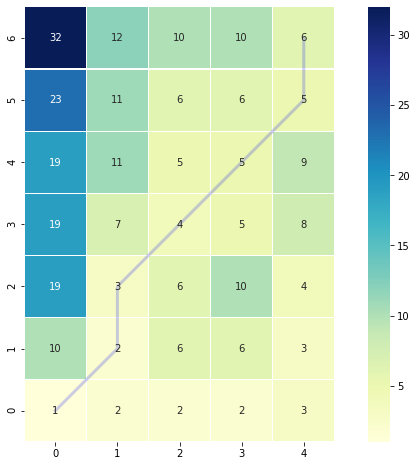

In [13]:
# example
x = [3, 1, 2, 2, 1]
y = [2, 0, 0, 3, 3, 1, 0]

dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)
print(dtw_distance)
print(warp_path)

cost_matrix = compute_accumulated_cost_matrix(x, y)

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2);
#fig.savefig("ex1_heatmap.png", **savefig_options)

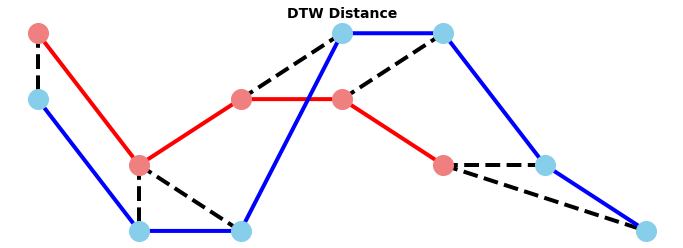

In [14]:
fig, ax = plt.subplots(figsize=(12,4))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x[map_x], y[map_y]], '--k', linewidth=4)

ax.plot(x, '-ro', label='x', linewidth=4, markersize=20, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=4, markersize=20, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("DTW Distance", fontsize=14, fontweight="bold");

##### Similarity Analysis

In [15]:
df_sa = pd.read_sas("data/distin.sas7bdat", format="sas7bdat", encoding="ISO-8859-1")
print(df_sa.shape)
df_sa.head()

(26, 3)


,date,x1,x2
0,2020-01-05,103.221575,110.443548
1,2020-01-12,87.097005,109.212275
2,2020-01-19,94.136495,108.728711
3,2020-01-26,96.816812,122.513489
4,2020-02-02,95.983361,104.826731


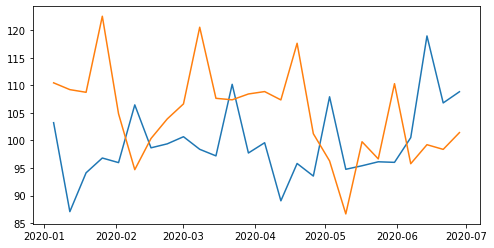

In [16]:
plt.figure(figsize=(8,4))
plt.plot(np.array(df_sa["date"]), np.array(df_sa["x1"]))
plt.plot(np.array(df_sa["date"]), np.array(df_sa["x2"]));

In [17]:
dtw_distance, warp_path = fastdtw(df_sa["x1"], df_sa["x2"], dist=euclidean)
print(dtw_distance)
print(warp_path)

195.69452249819653
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 5), (2, 5), (3, 5), (4, 5), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (10, 6), (11, 6), (12, 6), (13, 6), (14, 6), (15, 6), (16, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 16), (19, 17), (20, 17), (21, 18), (22, 19), (22, 20), (23, 21), (24, 22), (24, 23), (24, 24), (25, 25)]


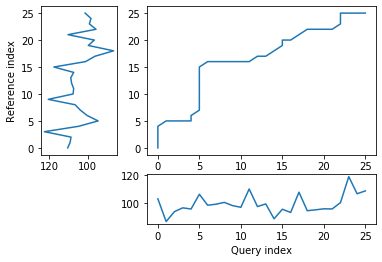

In [18]:
alignment = dtw(df_sa["x1"], df_sa["x2"], keep_internals=True)
alignment.plot(type="threeway");

The optimal path through the distance matrix shows evidence of target compression and expansion. There are more steps on this path than on a path generated under "no warping restriction", but the cost of traversing this path is smaller.

#### **Spectral Analysis Basics**

##### Fourier Analysis

Fourier analysis is a method for expressing a function as a sum of periodic components, and for recovering the signal from those components. When both the function and its Fourier transform are replaced with discretized counterparts, it is called the discrete Fourier transform (DFT).

In [20]:
df_al = pd.read_csv("data/aluminum.csv")
print(df_al.shape)
df_al.head()

(500000, 3)


,date,time,aluminum
0,2018-01-01 01:00:00,1.0,7.883315
1,2018-01-01 02:00:00,2.0,5.490949
2,2018-01-01 03:00:00,3.0,6.109361
3,2018-01-01 04:00:00,4.0,7.263154
4,2018-01-01 05:00:00,5.0,5.968076


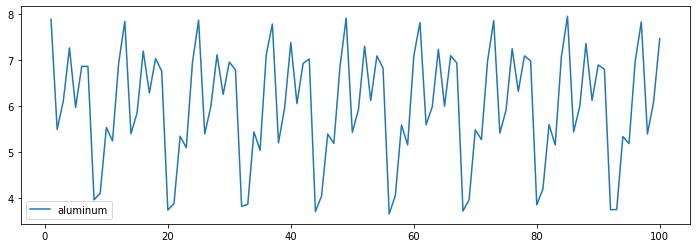

In [21]:
n = 100
plt.figure(figsize=(12,4))
plt.plot(df_al["time"][:n].values, df_al["aluminum"][:n].values, label="aluminum")
plt.legend();

The signal or deterministic part of the data consists of three sinusoids with periods of 3, 6, and 12 intervals. The aluminum sequence (signal) is a linear combination of these three sinusoids and a white noise error sequence (see dataframe).

In [22]:
n = 500
freq = np.arange(0, 1, 1/n)
period = np.array([0] + [1/f for f in freq if f > 0])

yf = np.fft.fft(df_al["aluminum"][:n])
X = yf.real
Y = yf.imag
power = np.array(X ** 2 + Y ** 2)

freq_ = freq[(freq > 0) & (freq <= 0.502)]
period_ = period[(freq > 0) & (freq <= 0.502)]
power_ = power[(freq > 0) & (freq <= 0.502)]

res = pd.DataFrame({"freq":freq_, "power":power_, "period":period_})
res = res[res["period"] < 50].sort_values(["period"])

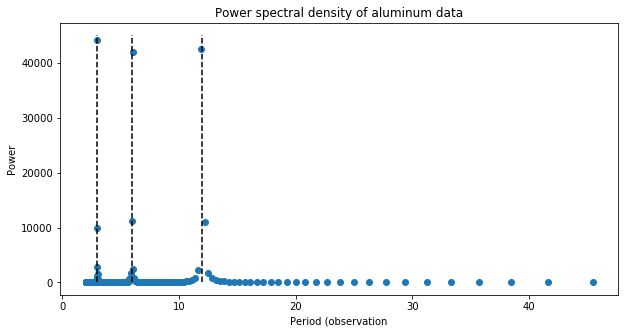

In [23]:
plt.figure(figsize=(10,5))
plt.scatter(x=res["period"], y=res["power"])
plt.vlines(3, 0, 45000, linestyles="dashed")
plt.vlines(6, 0, 45000, linestyles="dashed")
plt.vlines(12, 0, 45000, linestyles="dashed")
plt.title("Power spectral density of aluminum data")
plt.xlabel("Period (observation")
plt.ylabel("Power");

The spectral density estimates provide information about individual cycles in the data. The estimated spectrum decomposes the signal into discrete frequencies or cycles.

#### Forecasting (with Prophet)

In [43]:
from fbprophet import Prophet

In [ ]:
df_p = df_al[["date", "aluminum"]].iloc[:500,:].copy()
df_p.columns = ["ds", "y"]
df_p["ds"] = pd.to_datetime(df_p["ds"])

m = Prophet(interval_width=0.95)
model = m.fit(df_p)

future = m.make_future_dataframe(periods=100, freq="H")
forecast = m.predict(future)
forecast.head()
m.plot(forecast);

#### Forecasting (with ARIMAX)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df = df_al.iloc[:500,:].copy()
df = df[["aluminum", "time"]].copy()
df["sin3"] = np.sin(2 * np.pi * df["time"] / 3)
df["cos3"] = np.cos(2 * np.pi * df["time"] / 3)
df["sin6"] = np.sin(2 * np.pi * df["time"] / 6)
df["cos6"] = np.cos(2 * np.pi * df["time"] / 6)
df["sin12"] = np.sin(2 * np.pi * df["time"] / 12)
df["cos12"] = np.cos(2 * np.pi * df["time"] / 12)

df_train = df.iloc[:400, :].copy()
df_test = df.iloc[400:,:].copy()

In [ ]:
model = ARIMA(df_train.aluminum, exog=df_train[["sin3", "cos3", "sin6", "cos6", "sin12", "cos12"]], order=(1,0,0)).fit()

In [ ]:
model.summary()

In [ ]:
future = model.predict(exog=df_test[["sin3", "cos3", "sin6", "cos6", "sin12", "cos12"]], start=400, end=499)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_train.index, df_train["aluminum"])
plt.scatter(df_train.index, df_train["aluminum"])
plt.plot(range(400, 500, 1), future);

##### Singular Spectrum Analysis

Singular spectrum analysis (SSA) decomposes a time series into a set of summable components that are grouped together and interpreted as trend, periodicity and noise. SSA emphasises separability of the underlying components, and can readily separate periodicities that occur on different time scales, even in very noisy time series data. The original time series is recovered by summing together all of its components.

For a detailed explanation of SSA see https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/notebook

The general procedure in SSA is as follows:

1.   Embed the time series by forming a Hankel matrix of lagged window (length K) vectors.
2.   Decompose the embedded time series via Singular Value Decomposition.
3.   Eigentripple Grouping is the process of identifying eigenvalue-eigenvector pairs as trend, seasonal and noise.
4.   Reconstruct the time series from the eigenvalue-eigenvector pairs identified as trend and seasonal. This is done through a process called diagonal averaging.

In [24]:
df_chem = pd.read_csv("data/chemflow.csv")
df_chem["timestamp"] = pd.to_datetime(df_chem["timestamp"])
df_chem = df_chem.set_index("timestamp")
df_chem["t"] = np.arange(1, df_chem.shape[0]+1)
df_chem["trend"] = .02*df_chem["t"] - 0.0000001*(df_chem["t"]**2)
df_chem["y"] = 300*df_chem["contaminant"] + df_chem["trend"]
print(df_chem.shape)
df_chem.head()

(131040, 4)


,y,contaminant,t,trend
timestamp,,,,
2012-06-02 00:00:00,4.636094,0.015387,1,0.020000
2012-06-02 00:01:00,2.698054,0.008860,2,0.040000
2012-06-02 00:02:00,-5.623903,-0.018946,3,0.059999
2012-06-02 00:03:00,8.507214,0.028091,4,0.079998
2012-06-02 00:04:00,-8.230786,-0.027769,5,0.099998


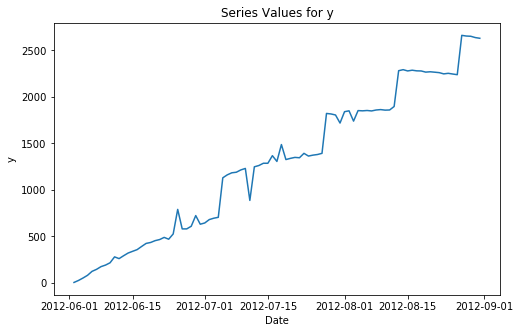

In [25]:
res = df_chem["y"].resample("D").first()
plt.figure(figsize=(8,5))
plt.plot(res)
plt.title("Series Values for y")
plt.xlabel("Date")
plt.ylabel("y");

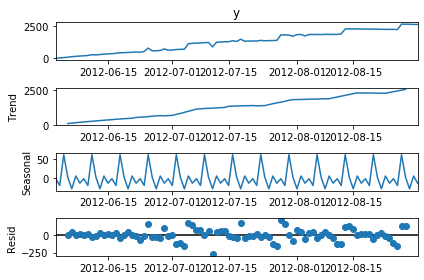

In [26]:
seasonal_decompose(res).plot();

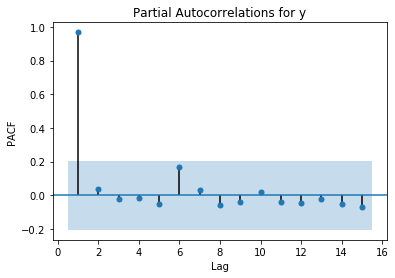

In [27]:
tsaplots.plot_pacf(res, lags=np.arange(1,16))
plt.title("Partial Autocorrelations for y")
plt.xlabel("Lag")
plt.ylabel("PACF");

In [28]:
#import sys
#sys.path.insert(0, "/content/drive/MyDrive/Data/Time_Series_SAS")
from mySSA import mySSA # https://github.com/aj-cloete/pssa/blob/master/Singular%20Spectrum%20Analysis%20Example.ipynb

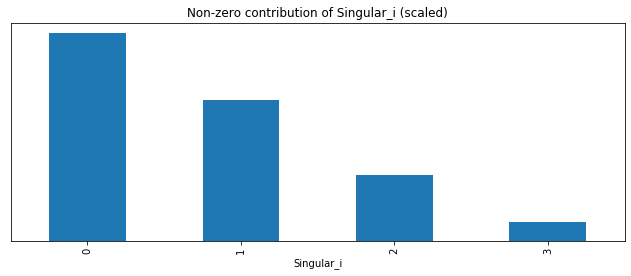

In [29]:
ssa = mySSA(res)
ssa.embed(embedding_dimension=4)
ssa.decompose()
ssa.view_s_contributions(adjust_scale=True)

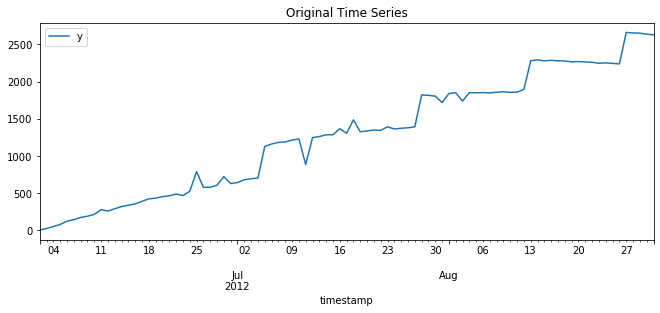

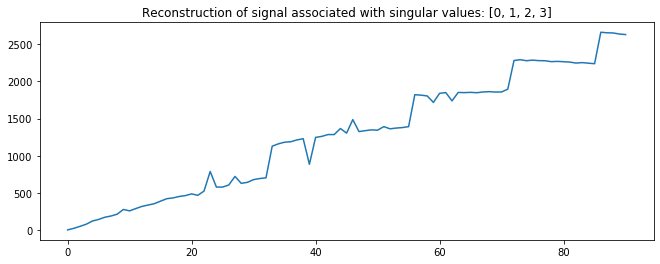

In [30]:
ssa.ts.plot(title="Original Time Series")
streams4 = [i for i in range(4)]
reconstructed4 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams4], names=streams4, return_df=True)

In [31]:
df_ag = pd.read_sas("data/ssain.sas7bdat", format="sas7bdat", encoding="ISO-8859-1")
df_ag = df_ag.set_index("date")
print(df_ag.shape)
df_ag.head()

(500000, 2)


,time,agseries2
date,,
2018-01-01 01:00:00,1.0,9.068918
2018-01-01 02:00:00,2.0,6.999253
2018-01-01 03:00:00,3.0,8.145303
2018-01-01 04:00:00,4.0,8.672263
2018-01-01 05:00:00,5.0,7.255009


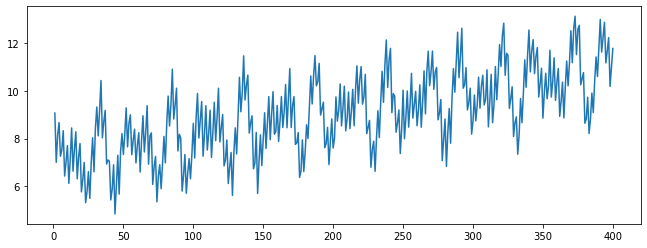

In [32]:
plt.plot(df_ag["time"][:400], df_ag["agseries2"][:400]);

In [33]:
ssa = mySSA(df_ag["agseries2"][:400])
ssa.embed(embedding_dimension=4)
ssa.decompose()

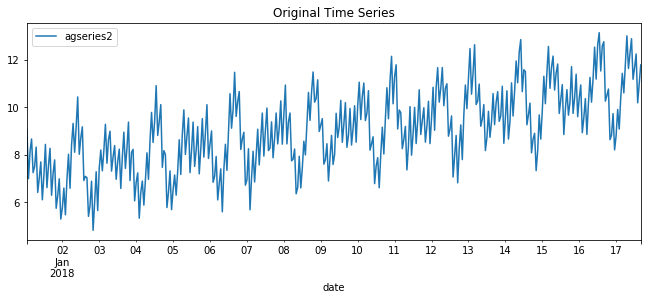

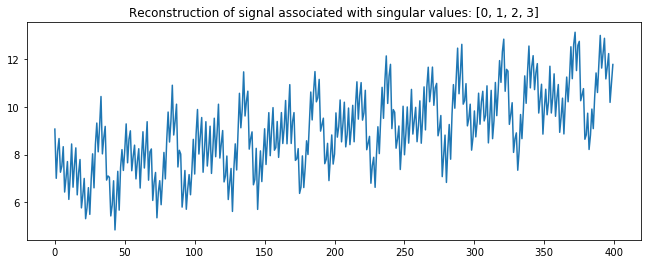

In [34]:
ssa.ts.plot(title="Original Time Series")
streams4 = [i for i in range(4)]
reconstructed4 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams4], names=streams4, return_df=True)

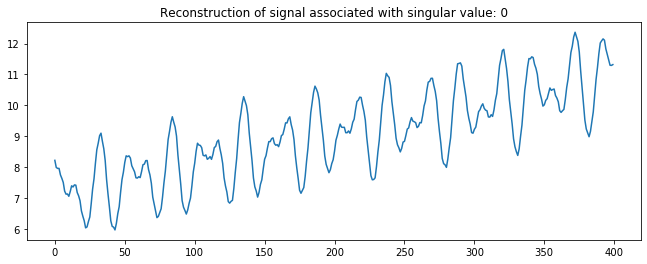

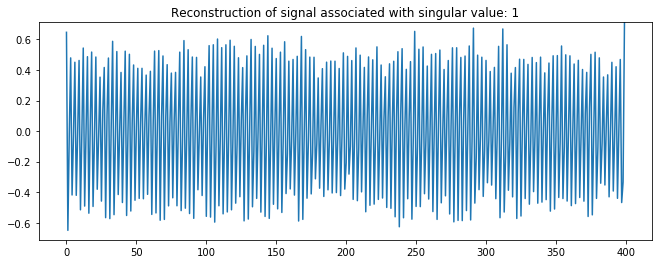

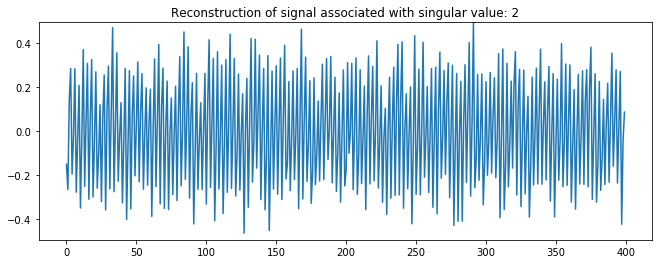

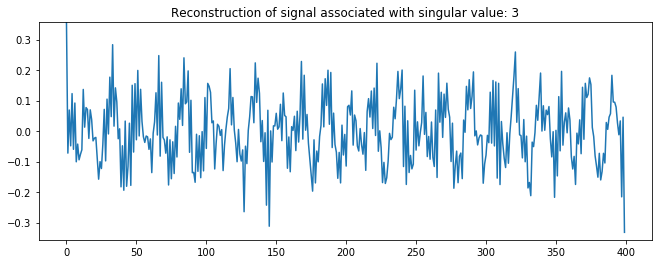

In [35]:
for i in range(4):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)

#### Motif Analysis Basics

Motif discovery has been successfully used in many sequence data applications.

In genetics, a recurring pattern in a DNA sequence fits our definition of a motif. Such a pattern may have biological significance and be important in gene regulation.

In physiological data, patterns in electrocardiograph activity can provide leading indicators of events like a heart attack or stroke.

A *matrix profile* is essentially a vector that stores the z-normalized Euclidean distance between any subsequence within a time series and its nearest neighbor.

In [36]:
import stumpy

##### Simple Repeating Motif

The data was generated using fuzzy models applied to mimic a steam generator at the Abbott Power Plant in Champaign, IL. The data feature that we are interested in is the output steam flow telemetry that has units of kg/s and the data is “sampled” every three seconds with a total of 9,600 datapoints.

In [37]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


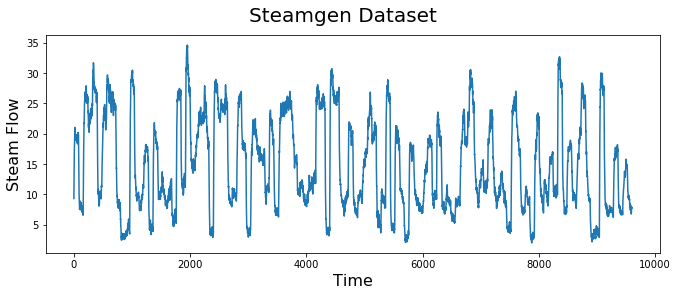

In [38]:
plt.suptitle('Steamgen Dataset', fontsize='20')
plt.xlabel('Time', fontsize ='16')
plt.ylabel('Steam Flow', fontsize='16')
plt.plot(steam_df['steam flow'].values);

In [39]:
m = 640 # window size (approximately half hour)
mp = stumpy.stump(steam_df['steam flow'], m)

In [40]:
# identify the index location of the motif
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")
nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")
print()
discord_idx = np.argsort(mp[:, 0])[-1]
print(f"The discord is located at index {discord_idx}")
nearest_neighbor_distance = mp[discord_idx, 0]
print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

The motif is located at index 643
The nearest neighbor is located at index 8724

The discord is located at index 3864
The nearest neighbor subsequence to this discord is 23.476168367301963 units away


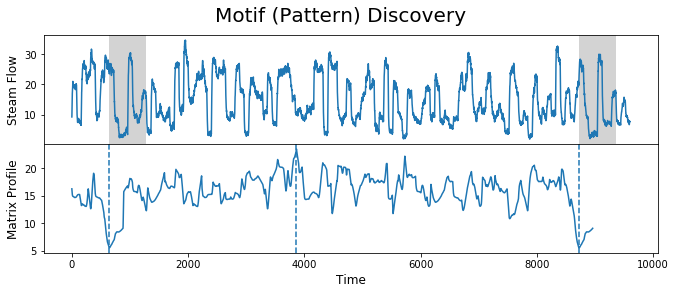

In [41]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='20');

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='12')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='12')
axs[1].set_ylabel('Matrix Profile', fontsize='12')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0]);

##### Time Series Chains

The data contains a decade-long GoogleTrend query volume (collected weekly from 2004-2014) for the keyword Kohl’s, an American retail chain.

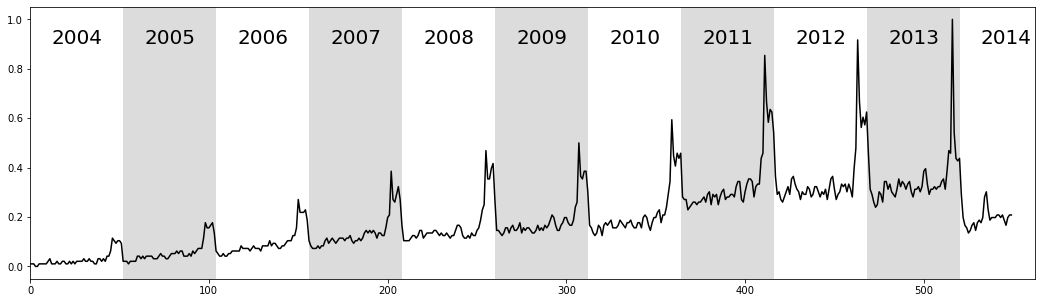

In [42]:
df = pd.read_csv("https://zenodo.org/record/4276348/files/Time_Series_Chains_Kohls_data.csv?download=1")
plt.figure(figsize=(18,5))
plt.plot(df['volume'], color='black')
plt.xlim(0, df.shape[0]+12)
color = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, df.shape[0], 52)):
    plt.text(x+12, 0.9, str(2004+i), color="black", fontsize=20)
    rect = Rectangle((x, -1), 52, 2.5, facecolor=next(color))
    plt.gca().add_patch(rect);

In [43]:
# compute matrix profile
m = 20 # approximate length of 'bumps'
mp = stumpy.stump(df["volume"], m=m)

In [44]:
# get all-chains and the unconditionally longest chain
all_chain_set, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])

##### Visualize the Unanchored Chain

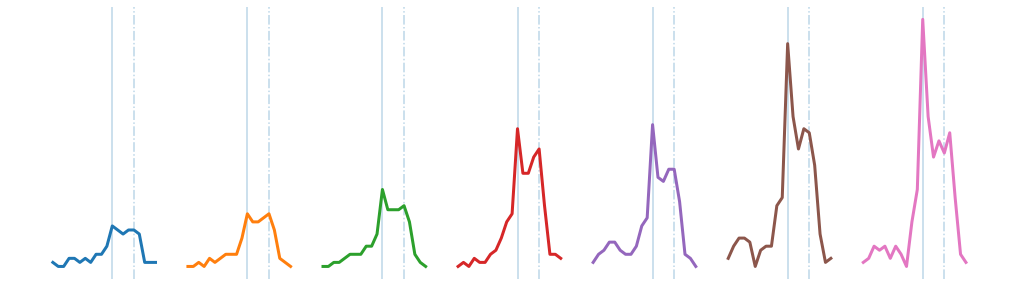

In [45]:
plt.figure(figsize=(18,5))
plt.axis('off')
for i in range(unanchored_chain.shape[0]):
    data = df['volume'].iloc[unanchored_chain[i]:unanchored_chain[i]+m].reset_index().values
    x = data[:, 0]
    y = data[:, 1]
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 11, alpha=0.3)
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 15, alpha=0.3, linestyle='-.')
    plt.plot(x-x.min()+(m+5)*i, y-y.min(), linewidth=3);

The discovered chain shows that over the decade, the bump transitions form a smooth bump covering the period between Thanksgiving (solid vertical line) and Christmas (dashed vertical line), to a more sharply focused bump centered on Thanksgiving. This seems to reflect the growing importance of “Cyber Monday”, a marketing term for the Monday after Thanksgiving.